
В данном домашнем задании вам необходимо обучить языковую модель (не более 1B параметров) решать примеры на сложение как можно более длинных чисел.

**Ожидаемый результат**

Необходимо предоставить код, а также технический отчет, содержащий описание метода и используемых данных, оценку качества (точность сложения).

**Пояснения**

1. Можно использовать любые предобученные модели, можно их файнтюнить, обучать с нуля, адаптировать любым другим способом или брать как есть. Главное, чтобы все использованные вами идеи, код или веса моделей были описаны в приложенном отчете со ссылкой на источник.

2. Мы ожидаем, что ваш код принимает на вход два числа (в виде строк их десятичной записи) и выдает ответ в любом человекочитаемом виде. Однако, если ваша модель работает с входом в виде предложения на естественном языке, это тоже нормально, главное, чтобы это было описано в отчете.

3. Можно оценить качество работы алгоритма, посчитав accuracy на случайных множествах чисел разной длины. Если вам кажется более подходящей другая метрика, мы примем ваше решение. Опишите вашу метрику и аргументируйте выбор в отчете.

**Подсказка**

В качестве ориентира можете использовать следующий репозиторий (https://github.com/liutiedong/goat). В нём реализовано сборка датасета для обучения и само обучение.

### Разбаловка

- [2 балла] Сбор датасета для обучения  
- [3 балла] Реализация скрипта модели
- [3 балла] Создание обученной модели с качеством (100% на числах длины < 10)
- [2 баллов] Валидация модели

Для валидации можно использовать и готовую языковую модель без получения баллов за 3 пункт

### Описание вашего решения

[TODO]

# Импорт библиотек

In [ ]:
!pip install transformers
!pip install datasets
!pip install peft
!pip install accelerate
!pip install sentencepiece
!pip install gradio
!pip install appdirs
!pip install loralib
!pip install black
!pip install black[jupyter]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB

In [1]:
import json
import numpy as np
import os.path as osp
import random
from typing import Union
from tqdm import tqdm

import os
import sys
from typing import List
from datasets import load_dataset

import torch
import torch.nn as nn

import transformers
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import Trainer
from transformers import TrainerCallback
from transformers import LlamaForCausalLM
from transformers import LlamaTokenizer


import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
sns.set()

from sklearn.metrics import mean_absolute_percentage_error


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Определение устройства для обучения (GPU или CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

path = 'drive/MyDrive/HW_5/'
if not os.path.exists(path):
    os.makedirs(path)
my_model='nickypro/tinyllama-15M'

# Создаем свой датасет

In [3]:
def random_dataset(N, output_file):
    # Создание пар чисел различной длины
    number_pairs = \
    [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(1, 14) for j in range(i, 14) for _ in range(N)] +\
    [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(3, 14) for j in range(i, 14) for _ in range(N)] +\
    [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(6, 14) for j in range(i, 14) for _ in range(N)] +\
    [(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(9, 14) for j in range(i, 14) for _ in range(N)]

    # Перемешивание пар чисел
    random.shuffle(number_pairs)

    print("Количество примеров на сложение:", len(number_pairs))

    addition_examples = []

    for first_num, second_num in number_pairs:
        # Случайный выбор порядка чисел
        if random.random() < 0.5:
            first_num, second_num = second_num, first_num

        sum_result = first_num + second_num

        question = f"{first_num} + {second_num}"
        output = f"{first_num} + {second_num} = {sum_result}"

        # Проверка корректности вычисления
        assert(output.split()[-1] == str(sum_result))
        addition_examples.append({"input": question, "output": output, "answer": str(sum_result),
                                  "instruction": question})

    # Сохранение данных в файл
    with open(output_file, "w") as f:
        json.dump(addition_examples, f, indent=4)

In [4]:
random_dataset(1000, f"{path}dataset.json")

Количество примеров на сложение: 208000


# Обучаем модель

In [5]:
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
    PeftModel
)

In [6]:
 class TextGeneratorHelper(object):
    # Функция для создания промпта, используемого моделью генерации текста
    def create_text_prompt(
        self,
        task_description: str,
        optional_label: Union[None, str] = None,
    ) -> str:
        """
        :param task_description: Описание задачи, которое будет представлено в промпте.
        :param optional_label: Дополнительная метка, которая может быть добавлена к промпту.
        :return: Сформированный промпт.
        """
        # Формирование основы промпта
        prompt = f"{task_description}\nAnswer: "

        # Добавление дополнительной метки к промпту, если он указан
        if optional_label:
            prompt = f"{prompt}{optional_label}"

        return prompt

    # Функция для извлечения ответа из сгенерированного текста модели
    def extract_model_response(self, model_output: str) -> str:
        """
        :param model_output: Текстовый вывод модели.
        :return: Обработанный ответ, извлеченный из вывода модели.
        """
        # Замена общепринятых символов на математические символы деления и умножения
        return model_output.split("Answer:")[1].strip().replace("/", "\u00F7").replace("*", "\u00D7")

In [7]:
class ModelSaverCallback(TrainerCallback):
    """
    Класс обратного вызова для сохранения модели в процессе обучения.
    """
    def __init__(self, tokenizer, model, output_dir):
        self.tokenizer = tokenizer
        self.model = model

    def on_save(self, args, state, control, **kwargs):
        """
        Функция вызывается при сохранении модели. Генерирует пример запроса,
        получает ответ от модели и выводит его.
        """
        text_helper = TextGeneratorHelper()
        prompt = text_helper.create_text_prompt("2851673 + 7678457")
        inputs = self.tokenizer(prompt, return_tensors="pt")

        input_ids = inputs["input_ids"].to(device)

        generation_output = self.model.generate(
                input_ids=input_ids,
                return_dict_in_generate=True,
                output_scores=True,
                pad_token_id=0,
                eos_token_id=self.tokenizer.eos_token_id,
                max_new_tokens=13
            )
        s = generation_output.sequences[0]
        print(self.tokenizer.decode(s, skip_special_tokens=True).strip())

In [9]:
def train(
    # Параметры модели и данных
    my_model: str = "",
    data_path: str = "/content/drive/MyDrive/HW_5/dataset.json",
    output_dir: str = "weights",

    # Гиперпараметры обучения
    batch_size: int = 128,
    micro_batch_size: int = 16,
    num_epochs: int = 10,
    learning_rate: float = 3e-4,
    cutoff_len: int = 512,
    val_set_size: int = 1000,

    # Параметры LoRA
    lora_r: int = 64,
    lora_alpha: int = 64,
    lora_dropout: float = 0.05,
    lora_target_modules: List[str] = [
        "q_proj", "v_proj", "k_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj", "lm_head"
    ],

    # Параметры LLM
    train_on_inputs: bool = False,  # Если False, то входы не учитываются в потерях
    group_by_length: bool = False,  # Быстрее, но может привести к странной кривой потерь

    resume_from_checkpoint: str = None,  # Чекпоинт для возобновления обучения
):
    # Проверка наличия указанной модели
    assert (
        my_model
        ), "Please specify a --my_model, e.g. --my_model='decapoda-research/llama-7b-hf'"

    gradient_accumulation_steps = batch_size // micro_batch_size

    text_helper = TextGeneratorHelper()

    # Настройка распределенного обучения, если необходимо
    device_map = "auto"
    world_size = int(os.environ.get("WORLD_SIZE", 1))
    ddp = world_size != 1
    if ddp:
        device_map = {"": int(os.environ.get("LOCAL_RANK") or 0)}
        gradient_accumulation_steps //= world_size

    # Инициализация модели и токенизатора
    model = LlamaForCausalLM.from_pretrained(
        my_model,
        # load_in_8bit=True,
        torch_dtype=torch.float32,
        device_map=device_map,
        offload_folder="offload"
    )

    tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')
    tokenizer.pad_token_id = 0
    tokenizer.padding_side = "left"  # Позволяет пакетную обработку

    # Определение функций для токенизации и генерации подсказок
    def tokenize(prompt, add_eos_token=True):
        """
        Токенизация текстового запроса.
        """
        result = tokenizer(
            prompt,
            truncation=True,
            max_length=cutoff_len,
            padding=False,
            return_tensors=None,
        )
        if (
            result["input_ids"][-1] != tokenizer.eos_token_id
            and len(result["input_ids"]) < cutoff_len
            and add_eos_token
        ):
            result["input_ids"].append(tokenizer.eos_token_id)
            result["attention_mask"].append(1)

        result["labels"] = result["input_ids"].copy()

        return result

    def generate_and_tokenize_prompt(data_point):
        """
        Генерация и токенизация запроса на основе данных.
        """
        full_prompt = text_helper.create_text_prompt(
            data_point["instruction"],
            data_point["answer"],
        )
        tokenized_full_prompt = tokenize(full_prompt)
        if not train_on_inputs:
            user_prompt = text_helper.create_text_prompt(
                data_point["instruction"]
            )
            tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
            user_prompt_len = len(tokenized_user_prompt["input_ids"])

            tokenized_full_prompt["labels"] = [
                -100
            ] * user_prompt_len + tokenized_full_prompt["labels"][
                user_prompt_len:
            ]
        return tokenized_full_prompt

    # Подготовка модели для обучения с использованием INT8
    model = prepare_model_for_int8_training(model)

    # Конфигурация LoRA
    config = LoraConfig(
        r=lora_r, lora_alpha=lora_alpha,
        target_modules=lora_target_modules,
        lora_dropout=lora_dropout, bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, config)

    # Загрузка данных для обучения
    if data_path.endswith(".json") or data_path.endswith(".jsonl"):
        data = load_dataset("json", data_files=data_path)
    else:
        data = load_dataset(data_path)

    # Возобновление обучения с чекпоинта, если указано
    if resume_from_checkpoint:
        checkpoint_name = os.path.join(
            resume_from_checkpoint, "pytorch_model.bin"
        )
        if not os.path.exists(checkpoint_name):
            checkpoint_name = os.path.join(
                resume_from_checkpoint, "adapter_model.bin"
            )
            resume_from_checkpoint = False

        if os.path.exists(checkpoint_name):
            print(f"Возобновление обучения с {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            model = set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Чекпоинт {checkpoint_name} не найден")

    model.print_trainable_parameters()  # Вывод информации о тренируемых параметрах

    # Разделение данных на обучающую и валидационную выборки
    if val_set_size > 0:
        train_val = data["train"].train_test_split(test_size=val_set_size, shuffle=True, seed=42)
        train_data = train_val["train"].shuffle().map(generate_and_tokenize_prompt)
        val_data = train_val["test"].shuffle().map(generate_and_tokenize_prompt)
    else:
        train_data = data["train"].shuffle().map(generate_and_tokenize_prompt)
        val_data = None

    # Настройка и запуск обучения
    trainer = transformers.Trainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        args=transformers.TrainingArguments(
            per_device_train_batch_size=micro_batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            warmup_steps=100,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            fp16=False,
            logging_steps=200,
            optim="adamw_torch",
            evaluation_strategy="steps" if val_set_size > 0 else "no",
            save_strategy="steps",
            eval_steps=200 if val_set_size > 0 else None,
            save_steps=200,
            output_dir=output_dir,
            save_total_limit=10,
            load_best_model_at_end=False if val_set_size > 0 else False,
            ddp_find_unused_parameters=False if ddp else None,
            group_by_length=group_by_length
        ),
        data_collator=transformers.DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
        ),
        callbacks=[ModelSaverCallback(tokenizer, model, output_dir)]
    )

    # Компиляция модели для оптимизации производительности
    if torch.__version__ >= "2" and sys.platform != "win32":
        model = torch.compile(model)

    # Запуск процесса обучения
    trainer.train(resume_from_checkpoint=resume_from_checkpoint)

    # Сохранение обученной модели
    model.save_pretrained(output_dir)

    print("\nЕсли выше есть предупреждение о недостающих ключах, проигнорируйте его.")

train(my_model=my_model)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

trainable params: 4,167,680 || all params: 19,359,392 || trainable%: 21.52794881161557


Map:   0%|          | 0/207000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
200,2.308500,1.626498
400,1.536700,1.482539
600,1.457100,1.426339
800,1.424900,1.401709
1000,1.403100,1.378175
1200,1.365400,1.336336
1400,1.329300,1.267709
1600,0.828800,0.578256
1800,0.472000,0.356621
2000,0.362400,0.237625


2851673 + 7678457
Answer: 10039937
2851673 + 7678457
Answer: 11116888
2851673 + 7678457
Answer: 10234433
2851673 + 7678457
Answer: 10443343
2851673 + 7678457
Answer: 10221111
2851673 + 7678457
Answer: 10154488
2851673 + 7678457
Answer: 10111119
2851673 + 7678457
Answer: 11429130
2851673 + 7678457
Answer: 11520120
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Answer: 0930019
2851673 + 7678457
Answer: 10529120
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10530130
2851673 + 7678457
Answer: 10520130
2851673 + 7678457
Ans

# Оценка по метрикам

Для оценки модели буду использовать метрики MAPE и accuracy.

In [10]:
random_dataset(30, output_file=f"{path}/validation_dataset.json")

Количество примеров на сложение: 6240


In [13]:
# Загрузка предварительно обученной модели Llama для каузального языкового моделирования
model = LlamaForCausalLM.from_pretrained(
    my_model,
    torch_dtype=torch.float32,
    device_map="auto",
)

# Загрузка модели Peft с конкретным чекпоинтом
model = PeftModel.from_pretrained(
    model,
    f'weights/checkpoint-16000',
    torch_dtype=torch.float32,
)

# Перевод модели в режим оценки (эвалюации)
model.eval()

# Компиляция модели для оптимизации производительности
if torch.__version__ >= "2" and sys.platform != "win32":
    model = torch.compile(model)

# Загрузка токенизатора Llama
tokenizer = LlamaTokenizer.from_pretrained('hf-internal-testing/llama-tokenizer')

# Установка ID токена для паддинга и настройка токенизатора
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

def generate_answers(instructions, model, tokenizer):
    """
    Генерирует ответы на предоставленные инструкции с помощью модели.

    :param instructions: Список инструкций для генерации ответов.
    :param model: Модель для генерации ответов.
    :param tokenizer: Токенизатор для обработки текста.
    :return: Список сырых ответов.
    """
    text_helper = TextGeneratorHelper()
    raw_answers = []

    # Генерация ответов для каждой инструкции
    for instruction in tqdm(instructions):
        prompt = text_helper.create_text_prompt(instruction)
        inputs = tokenizer(prompt, return_tensors="pt")

        input_ids = inputs["input_ids"].to(device)

        generation_output = model.generate(
            input_ids=input_ids,
            return_dict_in_generate=True,
            output_scores=True,
            pad_token_id=0,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=16
        )
        sequence = generation_output.sequences[0]
        raw_answers.append(tokenizer.decode(sequence, skip_special_tokens=True).strip())

    return raw_answers

In [14]:
def accuracy(true_answers, answers):
    num = 0
    for i in range(len(answers)):
        if true_answers[i] == answers[i]:
            num += 1
    return num / len(answers)


metrics = {
    'Accuracy': accuracy,
    'MAPE': mean_absolute_percentage_error
}

In [15]:
with open(f"{path}validation_dataset.json", 'r') as f:
    validation_data = json.load(f)


instructions = [el['instruction'] for el in validation_data]
right_answers = [int(el['answer']) for el in validation_data]

raw_answers = generate_answers(instructions, model, tokenizer)

100%|██████████| 6240/6240 [16:17<00:00,  6.38it/s]


In [16]:
generate_answers(["2851673 + 7678457"], model, tokenizer)

100%|██████████| 1/1 [00:00<00:00,  8.39it/s]


['2851673 + 7678457\nAnswer: 10530130']

In [17]:
def extract_number(raw_answer):
    """
    Извлекает числовое значение из ответа модели.

    :param raw_answer: текстовый ответ модели.
    :return: Целочисленное значение, извлеченное из ответа. В случае ошибки возвращает 0.
    """
    try:
        return int("".join(list(filter(lambda x: x.isdigit(), raw_answer.split('\n')[1].split(':')[1]))))
    except:
        return 0

answers = list(map(extract_number, raw_answers))
answers[0:5]

[3007801558489, 822690194726, 127, 32114758, 7432390518]

In [18]:
def compute_metrics_by_length(instructions, right_answers, answers):
    """
    Вычисляет метрики по длине для заданных инструкций и ответов.

    :param instructions: Список инструкций.
    :param right_answers: Список правильных ответов.
    :param answers: Список ответов, полученных от модели.
    :return: Словарь с метриками для каждой комбинации длин чисел в инструкциях.
    """
    result = {}
    for i in range(len(instructions)):
        # Вычисление длины каждого числа в инструкции
        lengths = tuple(map(lambda x: len(x.strip()), instructions[i].split('+')))

        # Инициализация словаря для новой комбинации длин
        if lengths not in result:
            result[lengths] = [[], []]

        # Добавление правильных и полученных ответов в соответствующие списки
        result[lengths][0].append(right_answers[i])
        result[lengths][1].append(answers[i])

    # Вычисление метрик для каждой комбинации длин
    result_metrics = {
        lengths: {
            metric: metrics[metric](result[lengths][0], result[lengths][1])
            for metric in metrics
        }
        for lengths in result
    }

    return result_metrics

metrics_dict = compute_metrics_by_length(instructions, right_answers, answers)

# Визуализация метрик

In [20]:
def visualize_metric(metrics_dict, metric):
  l1, l2, m_val = [], [], []
  for key, val in metrics_dict.items():
    l1.append(key[0])
    l2.append(key[1])
    m_val.append(val[metric])

  df = pd.DataFrame({
      'l1': l1,
      'l2': l2,
      'metric': m_val
  })



  result = pd.pivot(df, index='l1', columns='l2')
  return result

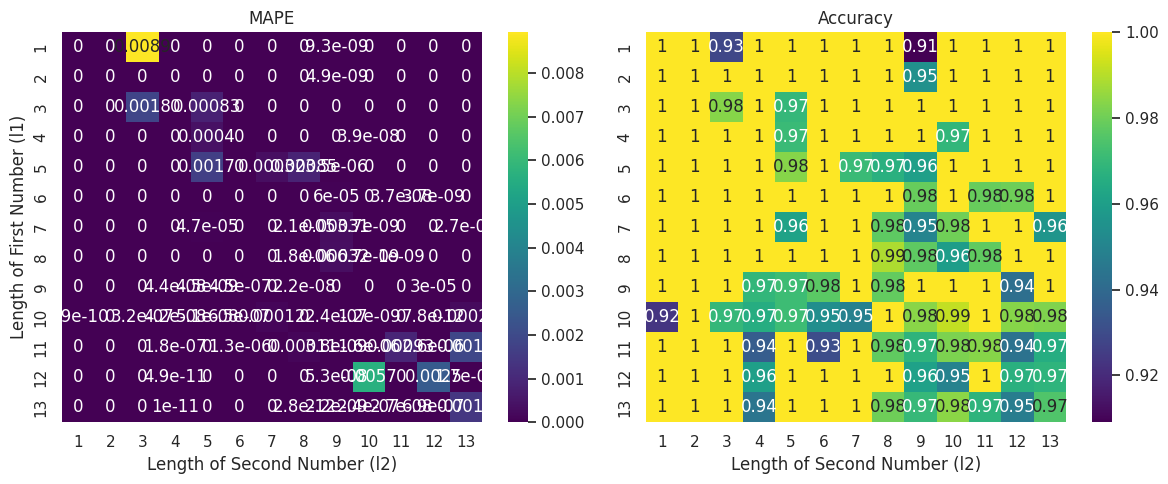

In [21]:
def visualize_metrics(metrics_dict, metrics):
    """
    Визуализирует несколько метрик с использованием тепловых карт.

    :param metrics_dict: Словарь с метриками.
    :param metrics: Список названий метрик для визуализации.
    """
    # Создание фигуры с несколькими подграфиками
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(num_metrics * 6, 5))

    for i, metric in enumerate(metrics):
        result = visualize_metric(metrics_dict, metric)
        sns.heatmap(result['metric'], ax=axes[i], annot=True, cmap='viridis')
        axes[i].set_title(metric)
        axes[i].set_xlabel('Length of Second Number (l2)')
        if i == 0:
            axes[i].set_ylabel('Length of First Number (l1)')
        else:
            axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

visualize_metrics(metrics_dict, ['MAPE', 'Accuracy'])

### *[1 балл] Дополнительное задание

Реализовать хостинг вашей модели на gradio

In [22]:
import gradio as gr

In [23]:
def evaluate(instruction):
    """
    Выполняет оценку (вычисление) для заданной арифметической инструкции.

    :param instruction: Текстовая строка с арифметической задачей.
    :return: Результат выполнения арифметической задачи.
    """
    # Генерация ответов для данной инструкции
    return generate_answers([instruction], model, tokenizer)[0]

# Создание веб-интерфейса с использованием Gradio
gr.Interface(
    fn=evaluate,  # Функция для обработки ввода
    inputs=[  # Компоненты для ввода данных пользователем
        gr.components.Textbox(
            lines=1,
            label="Арифметика",
            placeholder="63303235 + 20239503",
        )
    ],
    outputs=[  # Компоненты для вывода результатов
        gr.Textbox(
            lines=5,
            label="Результат",
        )
    ],
    title="Арифметическая LLaMA",  # Заголовок интерфейса
    description="Эта модель - 15M llama, дообученная на задачах a+b",  # Описание интерфейса
).queue().launch(server_name="0.0.0.0")  # Запуск веб-интерфейса

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7b61aa173b1043432c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Выводы

В этом задании вы научились решать арифметические действия с помощью языковой модели.